# **Initialization**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Hide all warnings
warnings.filterwarnings('ignore')

In [2]:
# Filepath init
filepath = 'https://github.com/gr-oll/susFin/raw/refs/heads/main/Data/'

# **Exercise 1**

In [3]:
# Install openpyxl if not already installed
%pip install openpyxl

# Extracting the data and formatting the dataset
monthly_return = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')
monthly_return_melted = monthly_return.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_return")
monthly_return_melted.rename(columns={'NAME': 'Name'}, inplace=True)

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Extracting the country-region dataset and merging it to the previous one
static = pd.read_excel(filepath + 'Static.xlsx')
df_ex1 = pd.merge(monthly_return_melted, static, on=['Name','ISIN'], how='outer')

In [5]:
# Filtering the rows of interest
df_ex1 = df_ex1[df_ex1['Region'] == 'PAC']
df_ex1 = df_ex1[(pd.to_datetime(df_ex1['year']) >= '2013-12-31') & (pd.to_datetime(df_ex1['year']) <= '2023-12-31')]

In [6]:
# Sorting to facilitate comprehension
df_ex1.sort_values(by=['Name', 'year'], inplace=True)

In [7]:
# New col with percentage change between two months
df_ex1['individual_monthly_return'] = df_ex1.groupby('Name')['monthly_return'].pct_change()

In [8]:
df_ex1

,Name,ISIN,year,monthly_return,Country,Region,individual_monthly_return
1074,77 BANK,JP3352000008,2013-12-31 00:00:00,0.68,JP,PAC,NaN
1075,77 BANK,JP3352000008,2014-01-31 00:00:00,0.66,JP,PAC,-0.029412
1076,77 BANK,JP3352000008,2014-02-28 00:00:00,0.62,JP,PAC,-0.060606
1077,77 BANK,JP3352000008,2014-03-31 00:00:00,0.64,JP,PAC,0.032258
1078,77 BANK,JP3352000008,2014-04-30 00:00:00,0.64,JP,PAC,0.000000
...,...,...,...,...,...,...,...
770389,YUEXIU PROPERTY COMPANY,HK0000745908,2023-08-31 00:00:00,62.82,HK,PAC,-0.055906
770390,YUEXIU PROPERTY COMPANY,HK0000745908,2023-09-29 00:00:00,58.43,HK,PAC,-0.069882
770391,YUEXIU PROPERTY COMPANY,HK0000745908,2023-10-31 00:00:00,54.23,HK,PAC,-0.071881
770392,YUEXIU PROPERTY COMPANY,HK0000745908,2023-11-30 00:00:00,47.52,HK,PAC,-0.123732


In [9]:
# Dropping the 31.12.2013 rows (not included in our timeframe but necessary for the pct_change of 31.12.2014)
df_ex1 = df_ex1[pd.to_datetime(df_ex1['year']).dt.year >= 2014]

In [10]:
# Filtering by non missing escores (2013-2024) complete dataset to allow comparisons
escore = pd.read_excel(filepath + 'DS_EScore_Y.xlsx')
melted_escore = escore.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="escore")
melted_escore.rename(columns={'NAME': 'Name'}, inplace=True)
melted_escore['year'] = pd.to_datetime(melted_escore['year'], format='%Y')
escore_interest = pd.merge(melted_escore, static, how='outer')
escore_interest = escore_interest[(escore_interest['year'] >= '2013-01-01') & (melted_escore['year'] <= '2024-12-31')]
escore_interest = escore_interest[escore_interest['Region'] == 'PAC']

In [11]:
filtered = escore_interest.groupby('ISIN')['escore'].count().reset_index()
filtered = filtered[filtered['escore'] == 11]

In [12]:
interest_companies = filtered['ISIN'].tolist()

In [13]:
# Filtering df_ex1 to include only non missing escores
df_ex1 = df_ex1[df_ex1['ISIN'].isin(interest_companies)]

In [14]:
df_ex1[df_ex1['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,Country,Region,individual_monthly_return
592512,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29 00:00:00,NaN,JP,PAC,0.0
592513,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31 00:00:00,NaN,JP,PAC,0.0
592514,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30 00:00:00,NaN,JP,PAC,0.0
592515,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29 00:00:00,NaN,JP,PAC,0.0
698819,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29 00:00:00,NaN,JP,PAC,0.0


In [15]:
# Individual handling of the 5 missings
df_ex1['individual_monthly_return'].loc[592512] = -1.
df_ex1['individual_monthly_return'].loc[592513] = np.nan
df_ex1['individual_monthly_return'].loc[592514] = np.nan
df_ex1['individual_monthly_return'].loc[592515] = np.nan
df_ex1['individual_monthly_return'].loc[698819] = -1.


In [16]:
# Creation of the averaged returns and their std + merge
annualization_mean = df_ex1.groupby('Name')['individual_monthly_return'].mean()
annualization_mean = pd.DataFrame(annualization_mean)
annualization_mean.rename(columns={'individual_monthly_return': 'monthly_mean'}, inplace=True)

annualization_var = df_ex1.groupby('Name')['individual_monthly_return'].std()
annualization_var = pd.DataFrame(annualization_var)
annualization_var.rename(columns={'individual_monthly_return': 'monthly_std'}, inplace=True)

annualization = pd.merge(annualization_mean, annualization_var, on='Name', how='outer')

In [17]:
# Creation of annualized cols
annualization['annualized_mean'] = annualization['monthly_mean'] * 12
annualization['annualized_std'] = annualization['monthly_std'] * np.sqrt(12)

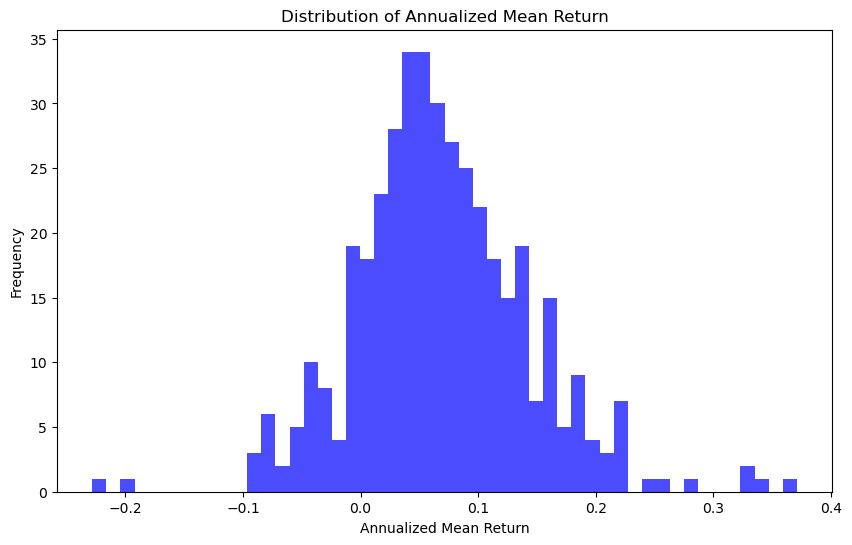

In [18]:
# Annualized mean histogram
plt.figure(figsize=(10, 6))
plt.hist(annualization['annualized_mean'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Annualized Mean Return')
plt.ylabel('Frequency')
plt.title('Distribution of Annualized Mean Return')
plt.show()

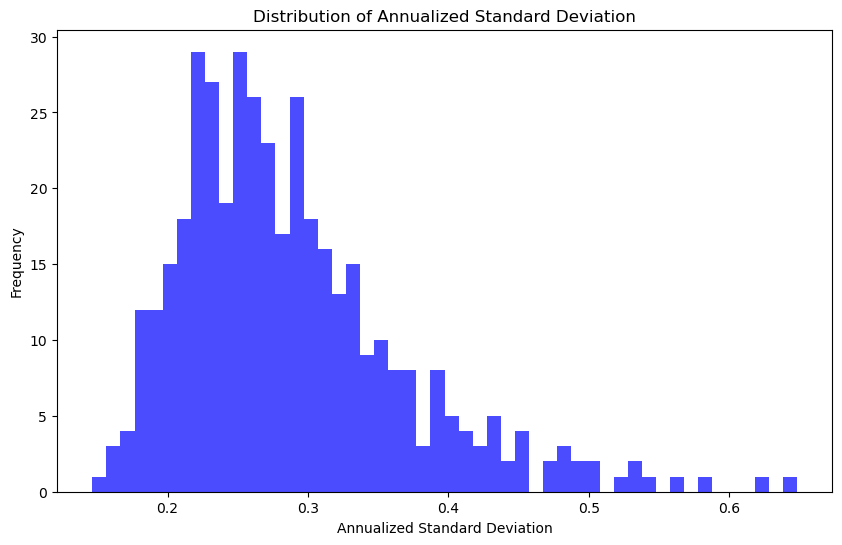

In [19]:
# Annualized std histogram
plt.figure(figsize=(10, 6))
plt.hist(annualization['annualized_std'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Annualized Standard Deviation')
plt.show()

In [20]:
# Variance-covariance matrix
np.corrcoef(annualization['annualized_mean'], annualization['annualized_std'])

array([[1.        , 0.08510139],
       [0.08510139, 1.        ]])

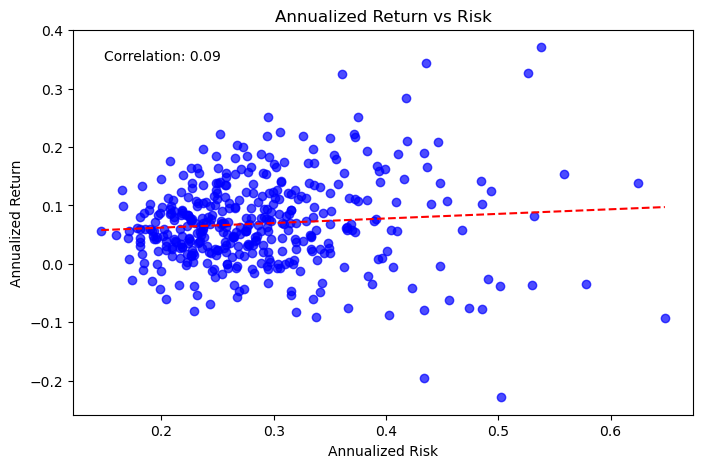

In [21]:
# Define annualized_returns DataFrame
annualized_returns = annualization[['annualized_std', 'annualized_mean']].rename(columns={'annualized_std': 'RISK', 'annualized_mean': 'RET_PCT'})

plt.figure(figsize=(8, 5))
plt.scatter(annualized_returns['RISK'], annualized_returns['RET_PCT'], color='blue', alpha=0.7)
plt.xlabel('Annualized Risk')
plt.ylabel('Annualized Return')
plt.title('Annualized Return vs Risk')

# Compute correlation
corr = annualized_returns['RISK'].corr(annualized_returns['RET_PCT'])

# Add a trendline
slope, intercept = np.polyfit(annualized_returns['RISK'], annualized_returns['RET_PCT'], 1)
x = np.linspace(annualized_returns['RISK'].min(), annualized_returns['RISK'].max(), 100)
y = slope * x + intercept
plt.plot(x, y, color='red', linestyle='--', label='Trendline')

# Display correlation on the plot
plt.text(
    0.05, 0.95,
    f'Correlation: {corr:.2f}',
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top'
)

plt.show()

# **Exercise 2**

In [22]:
# Extracting and merging monthly datasets
#monthly returns with dididend payments
M_ret = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')
melted_M_ret = M_ret.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_return")
melted_M_ret['year'] = pd.to_datetime(melted_M_ret['year'], format='%Y-%m-%d')
#monthly market value
M_mval = pd.read_excel(filepath + 'DS_MV_USD_M.xlsx')
melted_M_mval = M_mval.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_market_value")
melted_M_mval['year'] = pd.to_datetime(melted_M_mval['year'], format='%Y-%m-%d')


In [23]:
# Risk-free rates dataset
risk_free = pd.read_excel(filepath + 'Risk_Free_Rate.xlsx')
risk_free.rename(columns={'Unnamed: 0': 'year'}, inplace=True)
risk_free['year'] = pd.to_datetime(risk_free['year'], format='%Y%m')

In [24]:
# Merging the datasets
df_ex2 = pd.merge(melted_M_ret, melted_M_mval, on=['NAME', 'ISIN', 'year'], how='outer')
df_ex2.rename(columns={'NAME': 'Name'}, inplace=True)
df_ex2 = pd.merge(df_ex2, static, on=['Name', 'ISIN'], how='outer')

In [25]:
# Filter region and years of interest
df_ex2 = df_ex2[df_ex2['Region'] == 'PAC']
df_ex2 = df_ex2[(df_ex2['year'] >= '2013-12-31') & (df_ex2['year'] <= '2023-12-31')]
df_ex2['year'] = pd.to_datetime(df_ex2['year'])

In [26]:
# Filter same companies as in ex1 (non missing escores from 2013 to 2024)
df_ex2 = df_ex2[df_ex2['ISIN'].isin(interest_companies)]

In [27]:
df_ex2[df_ex2['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,monthly_market_value,Country,Region
592512,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29,NaN,0.0,JP,PAC
592513,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31,NaN,0.0,JP,PAC
592514,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30,NaN,0.0,JP,PAC
592515,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29,NaN,0.0,JP,PAC
698819,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,0.0,JP,PAC


In [28]:
# Returns percentage change and drop the 31.12.2013 rows
df_ex2['pct_monthly_return'] = df_ex2.groupby('Name')['monthly_return'].pct_change()
df_ex2 = df_ex2[pd.to_datetime(df_ex2['year']).dt.year >= 2014]

In [29]:
# Individual handling of the 5 missings
df_ex2['pct_monthly_return'].loc[592512] = -1.
df_ex2['pct_monthly_return'].loc[592513] = np.nan
df_ex2['pct_monthly_return'].loc[592514] = np.nan
df_ex2['pct_monthly_return'].loc[592515] = np.nan
df_ex2['pct_monthly_return'].loc[698819] = -1.


In [30]:
df_ex2[df_ex2['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,monthly_market_value,Country,Region,pct_monthly_return
592512,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29,NaN,0.0,JP,PAC,-1.0
592513,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31,NaN,0.0,JP,PAC,NaN
592514,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30,NaN,0.0,JP,PAC,NaN
592515,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29,NaN,0.0,JP,PAC,NaN
698819,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,0.0,JP,PAC,-1.0


In [31]:
# Building the equally weighted portfolio
ew_pf = df_ex2.groupby('year')['pct_monthly_return'].sum().reset_index()

In [32]:
# Dividing the return by the number of assets for each month
ew_pf['ew_m_ret'] = 0
for month in df_ex2['year'].unique():
    ew_pf.loc[ew_pf['year'] == month, 'ew_m_ret'] = ew_pf.loc[ew_pf['year'] == month, 'pct_monthly_return'] / len(df_ex2[df_ex2['year'] == month]['Name'].unique())

In [33]:
# Calculate the market value share
df_ex2['mv_share'] = df_ex2['monthly_market_value'] / df_ex2.groupby('year')['monthly_market_value'].transform('sum')

In [34]:
# Weight the returns by the market value share shifted as in the exercise sheet
df_ex2['mv_return'] = df_ex2['pct_monthly_return'] * df_ex2['mv_share'].shift(1)

In [35]:
# Market value weighted portfolio
mw_pf = df_ex2.groupby('year')['mv_return'].sum().reset_index()

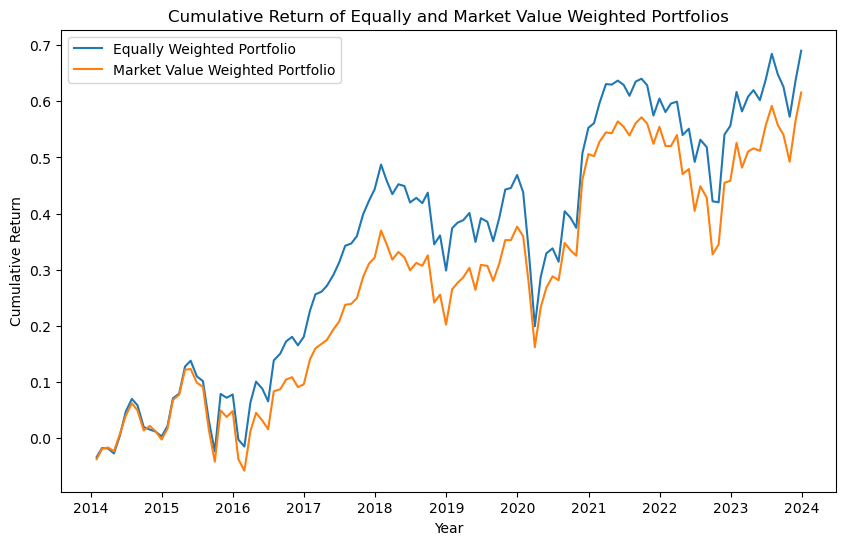

In [36]:
# Plot the monthly adapted returns for both portfolios
plt.figure(figsize=(10, 6))
plt.plot(ew_pf['year'], ew_pf['ew_m_ret'].cumsum(), label='Equally Weighted Portfolio')
plt.plot(mw_pf['year'], mw_pf['mv_return'].cumsum(), label='Market Value Weighted Portfolio')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return of Equally and Market Value Weighted Portfolios')
plt.legend()
plt.show()

In [37]:
# Risk free rate in the given period 
risk_free = risk_free[(pd.to_datetime(risk_free['year']).dt.year >= 2014) & (pd.to_datetime(risk_free['year']).dt.year <= 2023)]
# Annualized risk free rate
ann_rf = risk_free['RF'].mean() * 12 / 100

In [38]:
# Statistics of interest Equally Weighted Portfolio
# Annualized return
ew_ann_ret = ew_pf['ew_m_ret'].mean() * 12
# Annualized std
ew_ann_std = ew_pf['ew_m_ret'].std() * np.sqrt(12)
#min return
ew_min_ret = ew_pf['ew_m_ret'].min()
#max return
ew_max_ret = ew_pf['ew_m_ret'].max()

# Statistics of interest Market Value Weighted Portfolio
# Annualized return
mw_ann_ret = mw_pf['mv_return'].mean() * 12
# Annualized std
mw_ann_std = mw_pf['mv_return'].std() * np.sqrt(12)
#min return
mw_min_ret = mw_pf['mv_return'].min()
#max return
mw_max_ret = mw_pf['mv_return'].max()


In [39]:
# Equally weighted Sharpe Ratio
ew_sharpe = (ew_ann_ret - ann_rf)/ ew_ann_std
ew_sharpe

0.38387887979603214

In [40]:
# Value weighted Sharpe Ratio
mw_sharpe = (mw_ann_ret - ann_rf)/ mw_ann_std
mw_sharpe


0.35568049703395765

In [41]:
statistics = pd.DataFrame({'Portfolio': ['Equally Weighted', 'Market Value Weighted'],
                           'Annualized Return': [ew_ann_ret, mw_ann_ret],
                           'Annualized Standard Deviation': [ew_ann_std, mw_ann_std],
                           'Sharpe Ratio': [ew_sharpe, mw_sharpe],
                           'Min Return': [ew_min_ret, mw_min_ret],
                           'Max Return': [ew_max_ret, mw_max_ret]})
statistics

,Portfolio,Annualized Return,Annualized Standard Deviation,Sharpe Ratio,Min Return,Max Return
0,Equally Weighted,0.069011,0.149373,0.383879,-0.136916,0.132389
1,Market Value Weighted,0.061567,0.140286,0.355680,-0.115458,0.135156


In [42]:
'''delisted = ['A2B AUSTRALIA DEAD - DELIST.12/04/24',
       'BENESSE HOLDINGS DEAD - DELIST.17/05/24',
       'CSR DEAD - DEAD.10/07/24', 'J S R DEAD - DELIST.25/06/24',
       'LAWSON DEAD - DELIST.24/07/24',
       'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23',
       'TOSHIBA DEAD - DELIST.20/12/23']'''

"delisted = ['A2B AUSTRALIA DEAD - DELIST.12/04/24',\n       'BENESSE HOLDINGS DEAD - DELIST.17/05/24',\n       'CSR DEAD - DEAD.10/07/24', 'J S R DEAD - DELIST.25/06/24',\n       'LAWSON DEAD - DELIST.24/07/24',\n       'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23',\n       'TOSHIBA DEAD - DELIST.20/12/23']"

In [43]:
annualization = annualization.reset_index()

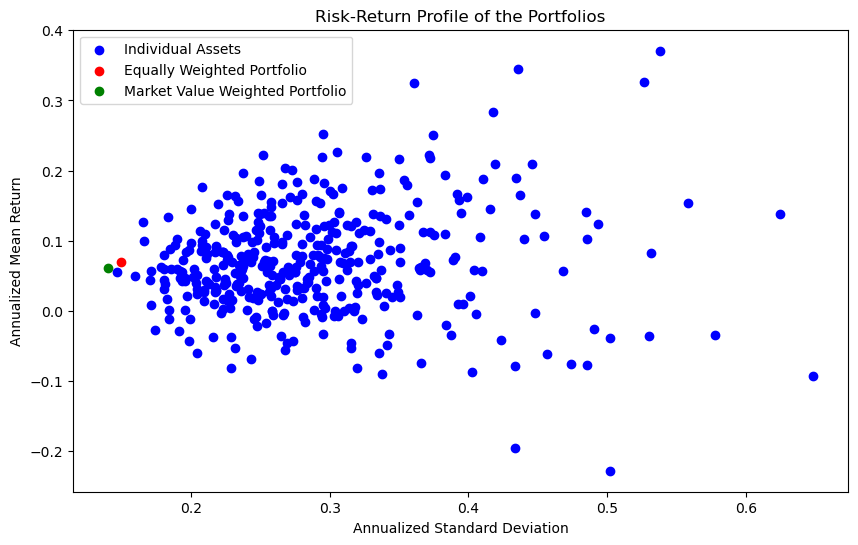

In [44]:
# Define the list of delisted companies
delisted = ['A2B AUSTRALIA DEAD - DELIST.12/04/24',
			'BENESSE HOLDINGS DEAD - DELIST.17/05/24',
			'CSR DEAD - DEAD.10/07/24', 
			'J S R DEAD - DELIST.25/06/24',
			'LAWSON DEAD - DELIST.24/07/24',
			'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23',
			'TOSHIBA DEAD - DELIST.20/12/23']

plt.figure(figsize=(10, 6))
plt.scatter(annualization['annualized_std'], annualization['annualized_mean'], color='blue', label='Individual Assets')
#plt.scatter(annualization[annualization['Name'].isin(delisted)]['annualized_std'], annualization[annualization['Name'].isin(delisted)]['annualized_mean'], color='cyan')
plt.scatter(ew_ann_std, ew_ann_ret, color='red', label='Equally Weighted Portfolio')
plt.scatter(mw_ann_std, mw_ann_ret, color='green', label='Market Value Weighted Portfolio')
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Mean Return')
plt.title('Risk-Return Profile of the Portfolios')
plt.legend()
plt.savefig('riskreturn.png')
plt.show()

# **Exercise 3**

In [45]:
# Extracting and merging monthly datasets
#monthly returns with dididend payments
M_ret = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')
melted_M_ret = M_ret.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_return")
melted_M_ret['year'] = pd.to_datetime(melted_M_ret['year'], format='%Y-%m-%d')
#monthly market value
M_mval = pd.read_excel(filepath + 'DS_MV_USD_M.xlsx')
melted_M_mval = M_mval.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_market_value")
melted_M_mval['year'] = pd.to_datetime(melted_M_mval['year'], format='%Y-%m-%d')
# Merging the datasets
df_ex3 = pd.merge(melted_M_ret, melted_M_mval, on=['NAME', 'ISIN', 'year'], how='outer')
df_ex3.rename(columns={'NAME': 'Name'}, inplace=True)
df_ex3 = pd.merge(df_ex3, static, on=['Name', 'ISIN'], how='outer')
# Filter region and years of interest
df_ex3 = df_ex3[df_ex3['Region'] == 'PAC']
df_ex3 = df_ex3[(df_ex3['year'] >= '2012-12-31') & (df_ex3['year'] <= '2023-12-31')]


In [46]:
# Filter df_ex3 to the same companies of interest as before (non missing escore from 2013 to 2024)
df_ex3 = df_ex3[df_ex3['ISIN'].isin(interest_companies)]

In [47]:
# Ensure the 'year' column in escore is datetime type
melted_escore['year'] = pd.to_datetime(melted_escore['year'], format='%Y')

# Merge the dataframes using merge_asof to align yearly escore data with monthly df_ex3 data
df_ex3 = pd.merge_asof(df_ex3.sort_values('year'), 
                                melted_escore.sort_values('year'), 
                                by=['Name', 'ISIN'], 
                                on='year', 
                                direction='backward')

In [48]:
# Returns percentage change and drop the 31.12.2012 rows
df_ex3['pct_monthly_return'] = df_ex3.groupby('Name')['monthly_return'].pct_change()
df_ex3 = df_ex3[pd.to_datetime(df_ex3['year']).dt.year >= 2013]

In [49]:
df_ex3.sort_values(by=['Name', 'year'], inplace=True)

In [50]:
df_ex3 = df_ex3[(df_ex3['year'].dt.year != 2013) & (df_ex3['year'].dt.year != 2012)]

In [51]:
df_ex3[df_ex3['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,monthly_market_value,Country,Region,escore,pct_monthly_return
52914,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29,NaN,0.0,JP,PAC,63.93,0.0
53307,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31,NaN,0.0,JP,PAC,63.93,0.0
53701,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30,NaN,0.0,JP,PAC,63.93,0.0
54106,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29,NaN,0.0,JP,PAC,63.93,0.0
54362,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,0.0,JP,PAC,89.52,0.0


In [52]:
# Individual handling of the 5 missings
df_ex3['pct_monthly_return'].loc[52914] = -1.
df_ex3['pct_monthly_return'].loc[53307] = np.nan
df_ex3['pct_monthly_return'].loc[53701] = np.nan
df_ex3['pct_monthly_return'].loc[54106] = np.nan
df_ex3['pct_monthly_return'].loc[54362] = -1.


In [53]:
# Create the variance-covariance matrix for pct_monthly_return
cov_matrix = df_ex3.pivot(index='year', columns='Name', values='pct_monthly_return').cov()

In [54]:
# Install scipy if not already installed
%pip install scipy

from scipy.optimize import minimize

Note: you may need to restart the kernel to use updated packages.


In [55]:
# Objective function: portfolio variance
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

In [56]:
# Number of assets
num_assets = len(cov_matrix)

# Initial guess for the weights
init_guess = num_assets * [1. / num_assets]

# Constraints: the sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights can only be between 0 and 1
bounds = tuple((0, 1) for asset in range(num_assets))

# Minimize the portfolio variance
result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
min_variance_weights = result.x

# Display the optimal weights
#min_variance_weights

In [57]:
minvar_pf = df_ex3.groupby('Name')['pct_monthly_return'].mean().reset_index()
minvar_pf['minvar_w'] = min_variance_weights
minvar_pf['annualized_mean'] = minvar_pf['pct_monthly_return'] * 12
minvar_pf['annualized_std'] = minvar_pf['pct_monthly_return'].std() * np.sqrt(12)
# Annualized mean
minvar_ann_ret = (minvar_pf['annualized_mean'] * minvar_pf['minvar_w']).sum()
# Annualized std
minvar_ann_std = minvar_pf['annualized_std'].std() * np.sqrt(12)

In [58]:
#min return
minvar_min_ret = minvar_pf['annualized_mean'].min()
#max return
minvar_max_ret = minvar_pf['annualized_mean'].max()
#minvar pf sharpe ratio
minvar_sharpe = (minvar_ann_ret - ann_rf)/ minvar_ann_std


In [59]:
# Objective function: negative portfolio return (to maximize return)
def portfolio_return(weights, returns):
    return -np.dot(weights, returns)

# Mean returns of the assets
mean_returns = df_ex3.groupby('Name')['pct_monthly_return'].mean().values

# Minimize the negative portfolio return
result_max_return = minimize(portfolio_return, init_guess, args=(mean_returns,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights for maximum return portfolio
max_return_weights = result_max_return.x

# Display the optimal weights
# max_return_weights

In [60]:
# Calculate the annualized return of the minimum variance portfolio
minvar_ann_ret = np.sum(min_variance_weights * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12

# Calculate the annualized standard deviation of the minimum variance portfolio
minvar_ann_std = np.sqrt(np.dot(min_variance_weights.T, np.dot(cov_matrix * 12, min_variance_weights)))

# Calculate the annualized return of the minimum variance portfolio
maxr_ann_ret = np.sum(max_return_weights * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12

# Calculate the annualized standard deviation of the minimum variance portfolio
maxr_ann_std = np.sqrt(np.dot(max_return_weights.T, np.dot(cov_matrix * 12, max_return_weights)))


In [61]:
maxr_pf = df_ex3.groupby('Name')['pct_monthly_return'].mean().reset_index()
maxr_pf['maxr_w'] = max_return_weights
maxr_pf['annualized_mean'] = maxr_pf['pct_monthly_return'] * 12
maxr_pf['annualized_std'] = maxr_pf['pct_monthly_return'].std() * np.sqrt(12)

In [62]:
#min return
maxr_min_ret = maxr_pf['annualized_mean'].min()
#max return
maxr_max_ret = maxr_pf['annualized_mean'].max()
#minvar pf sharpe ratio
maxr_sharpe = (maxr_ann_ret - ann_rf)/ maxr_ann_std

In [63]:
statistics = pd.DataFrame({'Portfolio': ['Minimum Variance Portfolio', 'Maximum Return Portfolio'],
                           'Annualized Return': [minvar_ann_ret, maxr_ann_ret],
                           'Annualized Standard Deviation': [minvar_ann_std, maxr_ann_std],
                           'Sharpe Ratio': [minvar_sharpe, maxr_sharpe],
                           'Min Return': [minvar_min_ret, maxr_min_ret],
                           'Max Return': [minvar_max_ret, maxr_max_ret]})
statistics

,Portfolio,Annualized Return,Annualized Standard Deviation,Sharpe Ratio,Min Return,Max Return
0,Minimum Variance Portfolio,0.052046,0.079459,2.396715e+14,-0.228193,0.370925
1,Maximum Return Portfolio,0.370925,0.538206,6.675044e-01,-0.228193,0.370925


In [ ]:
# Compute the efficient frontier portofolios
target_returns = np.linspace(minvar_ann_ret, maxr_ann_ret, 20)
efficient_frontier = []
for target in target_returns:
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: np.sum(x * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12 - target})
    result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    efficient_frontier.append(result.x)

In [ ]:
# Calculate the annualized return and standard deviation for each set of weights in the efficient frontier
target_ann_ret = []
target_ann_std = []

for weights in efficient_frontier:
	ann_ret = np.sum(weights * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12
	ann_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))
	target_ann_ret.append(ann_ret)
	target_ann_std.append(ann_std)

# Convert lists to numpy arrays
target_ann_ret = np.array(target_ann_ret)
target_ann_std = np.array(target_ann_std)

In [ ]:
monthly_rf = risk_free['RF'].mean() / 100 # professor said it in the mail
ann_rf = monthly_rf * 12  # professor explicitly defined annualization as simple multiplication

# Annualized returns and covariance
mean_returns_monthly = df_ex3.groupby('Name')['pct_monthly_return'].mean()
cov_matrix_monthly = df_ex3.pivot(index='year', columns='Name', values='pct_monthly_return').cov()

mean_returns_annual = mean_returns_monthly * 12
cov_matrix_annual = cov_matrix_monthly * 12

num_assets = len(mean_returns_annual)

# Optimization constraints and bounds
init_guess = np.ones(num_assets) / num_assets
bounds = tuple((0, 1) for _ in range(num_assets))
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Minimum Variance Portfolio
res_minvar = minimize(portfolio_variance, init_guess, args=(cov_matrix_annual,), method='SLSQP', bounds=bounds, constraints=constraints)
minvar_weights = res_minvar.x
minvar_ann_ret = np.dot(minvar_weights, mean_returns_annual)
minvar_ann_std = np.sqrt(portfolio_variance(minvar_weights, cov_matrix_annual))

# Define the negative portfolio return function
def negative_portfolio_return(weights, mean_returns):
    return -np.sum(weights * mean_returns)

# Maximum Return Portfolio
res_maxret = minimize(negative_portfolio_return, init_guess, args=(mean_returns_annual,), method='SLSQP', bounds=bounds, constraints=constraints)
maxr_weights = res_maxret.x
maxr_ann_ret = np.sum(maxr_weights * mean_returns_annual)
maxr_ann_std = np.sqrt(np.dot(maxr_weights.T, np.dot(cov_matrix_annual, maxr_weights)))

# Efficient frontier
n_portfolios = 5
target_returns = np.linspace(minvar_ann_ret, maxr_ann_ret, n_portfolios)
efficient_frontier_std, efficient_frontier_ret = [], []

for target in target_returns:
    constraints_ef = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.sum(x * mean_returns_annual) - target}
    )
    res_ef = minimize(portfolio_variance, init_guess, args=(cov_matrix_annual,), method='SLSQP', bounds=bounds, constraints=constraints_ef)
    w_opt = res_ef.x
    efficient_frontier_std.append(np.sqrt(np.dot(w_opt.T, np.dot(cov_matrix_annual, w_opt))))
    efficient_frontier_ret.append(target)

# Define the negative Sharpe ratio function
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
    return -sharpe_ratio

# Tangency portfolio (maximum Sharpe ratio)
res_tan = minimize(negative_sharpe_ratio, init_guess,
                   args=(mean_returns_annual, cov_matrix_annual, ann_rf),
                   method='SLSQP', bounds=bounds, constraints=constraints)

tan_weights = res_tan.x
tan_ret = np.dot(tan_weights, mean_returns_annual)
tan_vol = np.sqrt(np.dot(tan_weights.T, np.dot(cov_matrix_annual, tan_weights)))


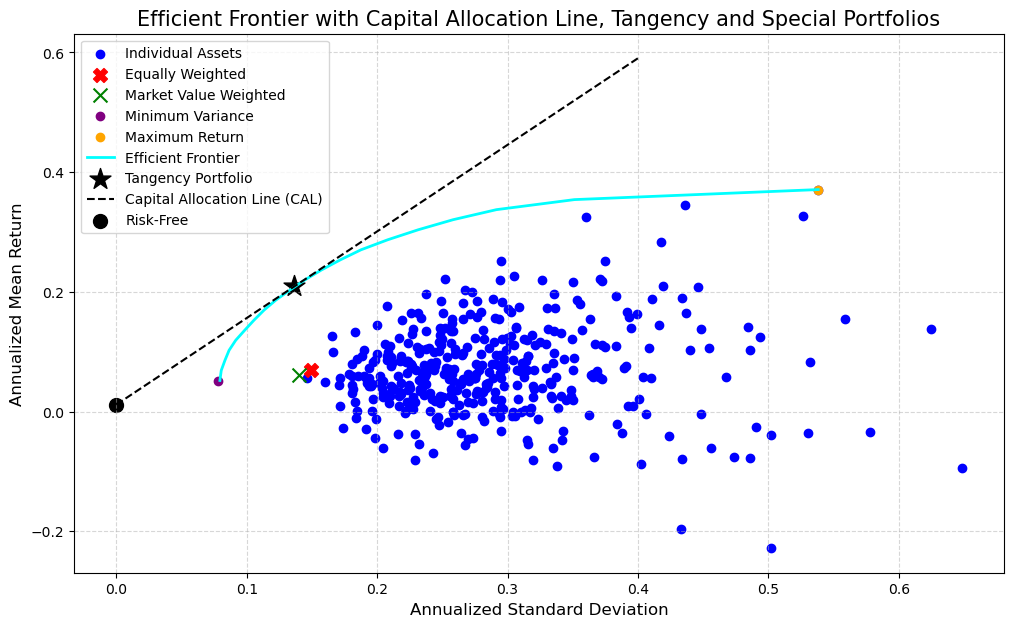

In [ ]:

# Final comprehensive plot
plt.figure(figsize=(12, 7))

# Individual assets
plt.scatter(annualization['annualized_std'], annualization['annualized_mean'], color='blue', label='Individual Assets')

# Equally Weighted Portfolio
plt.scatter(ew_ann_std, ew_ann_ret, color='red', marker='X', s=100, label='Equally Weighted')

# Market Value Weighted Portfolio
plt.scatter(mw_ann_std, mw_ann_ret, color='green', marker='x', s=100, label='Market Value Weighted')

# Min Variance Portfolio
plt.scatter(minvar_ann_std, minvar_ann_ret, color='purple', label='Minimum Variance')

# Max Return Portfolio
plt.scatter(maxr_ann_std, maxr_ann_ret, color='orange', label='Maximum Return')

# Efficient frontier
plt.plot(target_ann_std, target_ann_ret, color='cyan', linewidth=2, label='Efficient Frontier')

# Tangency Portfolio
plt.scatter(tan_vol, tan_ret, marker='*', color='black', s=250, label='Tangency Portfolio')

# Capital Allocation Line (CAL)
sigma_range = np.linspace(0, 0.4, 100)
cal_line = ann_rf + (tan_ret - ann_rf)/tan_vol * sigma_range
plt.plot(sigma_range, cal_line, color='black', linestyle='--', label='Capital Allocation Line (CAL)')

# Risk-Free asset
plt.scatter(0, ann_rf, color='black', marker='o', s=100, label='Risk-Free')

# Labels and title
plt.xlabel('Annualized Standard Deviation', fontsize=12)
plt.ylabel('Annualized Mean Return', fontsize=12)
plt.title('Efficient Frontier with Capital Allocation Line, Tangency and Special Portfolios', fontsize=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# Compute ex-post returns for each portfolio along the efficient frontier
ex_post_returns = []

for i in efficient_frontier:
    monthly_returns = df_ex3.pivot(index='year', columns='Name', values='pct_monthly_return')
    portfolio_returns = monthly_returns.dot(i)
    ex_post_returns.append(portfolio_returns)

# Calculate ex-post annualized average return, annualized volatility, and Sharpe ratio
ex_post_ann_ret = []
ex_post_ann_std = []
ex_post_sharpe = []

for returns in ex_post_returns:
    ann_ret = returns.mean() * 12
    ann_std = returns.std() * np.sqrt(12)
    sharpe_ratio = (ann_ret - ann_rf) / ann_std
    ex_post_ann_ret.append(ann_ret)
    ex_post_ann_std.append(ann_std)
    ex_post_sharpe.append(sharpe_ratio)

# Find the portfolio with the highest ex-ante and ex-post Sharpe ratio
max_ex_ante_sharpe_idx = np.argmax(target_ann_ret / target_ann_std)
max_ex_post_sharpe_idx = np.argmax(ex_post_sharpe)

'''# Plot the efficient frontier, individual assets, capital allocation line, and portfolios
plt.figure(figsize=(12, 7))

# Individual assets
plt.scatter(annualization['annualized_std'], annualization['annualized_mean'], color='blue', label='Individual Assets')

# Equally Weighted Portfolio
plt.scatter(ew_ann_std, ew_ann_ret, color='red', marker='X', s=100, label='Equally Weighted')

# Market Value Weighted Portfolio
plt.scatter(mw_ann_std, mw_ann_ret, color='green', marker='x', s=100, label='Market Value Weighted')
# Min Variance Portfolio
plt.scatter(minvar_ann_std, minvar_ann_ret, color='purple', label='Minimum Variance')

# Max Return Portfolio
plt.scatter(maxr_ann_std, maxr_ann_ret, color='orange', label='Maximum Return')

# Efficient frontier
plt.plot(target_ann_std, target_ann_ret, color='cyan', linewidth=2, label='Efficient Frontier')

# Capital Allocation Line (CAL)
sigma_range = np.linspace(0, 0.4, 100)
cal_line = ann_rf + (tan_ret - ann_rf)/tan_vol * sigma_range
plt.plot(sigma_range, cal_line, color='black', linestyle='--', label='Capital Allocation Line (CAL)')

# Risk-Free asset
plt.scatter(0, ann_rf, color='black', marker='o', s=100, label='Risk-Free')
#Tangency Portfolio
plt.scatter(tan_vol, tan_ret, marker='*', color='black', s=150, label='Tangency Portfolio')


# Highlight the portfolios with the highest ex-ante and ex-post Sharpe ratio
plt.scatter(target_ann_std[max_ex_ante_sharpe_idx], target_ann_ret[max_ex_ante_sharpe_idx], color='brown', s=40, label='Max Ex-Ante Sharpe Ratio')
plt.scatter(ex_post_ann_std[max_ex_post_sharpe_idx], ex_post_ann_ret[max_ex_post_sharpe_idx], color='indigo', s=40, label='Max Ex-Post Sharpe Ratio')

# Labels and title
plt.xlabel('Annualized Standard Deviation', fontsize=12)
plt.ylabel('Annualized Mean Return', fontsize=12)
plt.title('Efficient Frontier with Capital Allocation Line, Tangency and Special Portfolios', fontsize=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()'''

# Print the performance metrics
print(f"Portfolio with highest ex-ante Sharpe ratio: {max_ex_ante_sharpe_idx}")
print(f"Ex-Ante Sharpe Ratio: {target_ann_ret[max_ex_ante_sharpe_idx] / target_ann_std[max_ex_ante_sharpe_idx]}")
print(f"Ex-Post Sharpe Ratio: {ex_post_sharpe[max_ex_ante_sharpe_idx]}")

print(f"Portfolio with highest ex-post Sharpe ratio: {max_ex_post_sharpe_idx}")
print(f"Ex-Ante Sharpe Ratio: {target_ann_ret[max_ex_post_sharpe_idx] / target_ann_std[max_ex_post_sharpe_idx]}")
print(f"Ex-Post Sharpe Ratio: {ex_post_sharpe[max_ex_post_sharpe_idx]}")

Portfolio with highest ex-ante Sharpe ratio: 9
Ex-Ante Sharpe Ratio: 1.5250736002025607
Ex-Post Sharpe Ratio: 1.4002455535196934
Portfolio with highest ex-post Sharpe ratio: 10
Ex-Ante Sharpe Ratio: 1.521761638073197
Ex-Post Sharpe Ratio: 1.4085019067714226


# **Exercise 4**

In [ ]:
# Setting df for ex 4 with the same companies as before
df_ex4 = pd.merge(monthly_return_melted, static, how='outer')
df_ex4 = df_ex4[df_ex4['Region'] == 'PAC']
df_ex4 = df_ex4[df_ex4['ISIN'].isin(interest_companies)]
df_ex4['year'] = pd.to_datetime(df_ex4['year'])

In [ ]:
# Filtering by the interesting timeframe
df_ex4 = df_ex4[(df_ex4['year'] >= '2003-12-01') & (df_ex4['year'] <= '2024-12-31')]

In [ ]:
# Computing the individual returns
df_ex4['pct_monthly_return'] = df_ex4.groupby('Name')['monthly_return'].pct_change()

/var/folders/pg/ms9txxdj6xj6l0sxpljp5j940000gn/T/ipykernel_30383/4046258413.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_ex4['pct_monthly_return'] = df_ex4.groupby('Name')['monthly_return'].pct_change()


In [ ]:
df_ex4

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return
954,77 BANK,JP3352000008,2003-12-31,0.70,JP,PAC,NaN
955,77 BANK,JP3352000008,2004-01-30,0.66,JP,PAC,-0.057143
956,77 BANK,JP3352000008,2004-02-27,0.68,JP,PAC,0.030303
957,77 BANK,JP3352000008,2004-03-31,0.78,JP,PAC,0.147059
958,77 BANK,JP3352000008,2004-04-30,0.75,JP,PAC,-0.038462
...,...,...,...,...,...,...,...
770401,YUEXIU PROPERTY COMPANY,HK0000745908,2024-08-30,28.09,HK,PAC,-0.182717
770402,YUEXIU PROPERTY COMPANY,HK0000745908,2024-09-30,43.97,HK,PAC,0.565326
770403,YUEXIU PROPERTY COMPANY,HK0000745908,2024-10-31,45.71,HK,PAC,0.039572
770404,YUEXIU PROPERTY COMPANY,HK0000745908,2024-11-29,40.20,HK,PAC,-0.120543


In [ ]:
# Drop December 2003
df_ex4 = df_ex4[df_ex4['year'] >= '2004-01-01']

In [ ]:
df_ex4[df_ex4['monthly_return'].isna()]['Name'].unique()

array(['A2B AUSTRALIA DEAD - DELIST.12/04/24', 'AOZORA BANK',
       'BENESSE HOLDINGS DEAD - DELIST.17/05/24', 'CHINA MENGNIU DAIRY',
       'CLEANAWAY WASTE MANAGEMENT', 'CSR DEAD - DEAD.10/07/24', 'DENA',
       'ELEC.POWER DEV.', 'INPEX', 'J S R DEAD - DELIST.25/06/24',
       'LAWSON DEAD - DELIST.24/07/24',
       'LINK REAL ESTATE INVESTMENT TRUST', 'OTSUKA HOLDINGS',
       'PACIFIC BASIN SHIP.',
       'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23', 'SEEK',
       'SOUTHERN CROSS MEDIA GROUP', 'SUMCO', 'T & D HOLDINGS',
       'TOSHIBA DEAD - DELIST.20/12/23'], dtype=object)

In [ ]:
# Individual handling of the 5 missings
'A2B AUSTRALIA DEAD - DELIST.12/04/24'
df_ex4['pct_monthly_return'].loc[2104] = -1.
df_ex4['pct_monthly_return'].loc[2105] = np.nan
df_ex4['pct_monthly_return'].loc[2106] = np.nan
df_ex4['pct_monthly_return'].loc[2107] = np.nan
df_ex4['pct_monthly_return'].loc[2108] = np.nan
df_ex4['pct_monthly_return'].loc[2109] = np.nan
df_ex4['pct_monthly_return'].loc[2110] = np.nan
df_ex4['pct_monthly_return'].loc[2111] = np.nan
df_ex4['pct_monthly_return'].loc[2112] = np.nan
'BENESSE HOLDINGS DEAD - DELIST.17/05/24'
df_ex4['pct_monthly_return'].loc[88477] = -1.
df_ex4['pct_monthly_return'].loc[88478] = np.nan
df_ex4['pct_monthly_return'].loc[88479] = np.nan
df_ex4['pct_monthly_return'].loc[88480] = np.nan
df_ex4['pct_monthly_return'].loc[88481] = np.nan
df_ex4['pct_monthly_return'].loc[88482] = np.nan
df_ex4['pct_monthly_return'].loc[88483] = np.nan
df_ex4['pct_monthly_return'].loc[88484] = np.nan
'CSR DEAD - DEAD.10/07/24'
df_ex4['pct_monthly_return'].loc[182401] = -1.
df_ex4['pct_monthly_return'].loc[182402] = np.nan
df_ex4['pct_monthly_return'].loc[182403] = np.nan
df_ex4['pct_monthly_return'].loc[182404] = np.nan
df_ex4['pct_monthly_return'].loc[182405] = np.nan
df_ex4['pct_monthly_return'].loc[182406] = np.nan
df_ex4['pct_monthly_return'].loc[182407] = np.nan
'J S R DEAD - DELIST.25/06/24'
df_ex4['pct_monthly_return'].loc[362998] = -1.
df_ex4['pct_monthly_return'].loc[362999] = np.nan
df_ex4['pct_monthly_return'].loc[363000] = np.nan
df_ex4['pct_monthly_return'].loc[363001] = np.nan
df_ex4['pct_monthly_return'].loc[363002] = np.nan
df_ex4['pct_monthly_return'].loc[363003] = np.nan
df_ex4['pct_monthly_return'].loc[363004] = np.nan
'LAWSON DEAD - DELIST.24/07/24'
df_ex4['pct_monthly_return'].loc[406186] = -1.
df_ex4['pct_monthly_return'].loc[406187] = np.nan
df_ex4['pct_monthly_return'].loc[406188] = np.nan
df_ex4['pct_monthly_return'].loc[406189] = np.nan
df_ex4['pct_monthly_return'].loc[406190] = np.nan
df_ex4['pct_monthly_return'].loc[406191] = np.nan
'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23'
df_ex4['pct_monthly_return'].loc[592512] = -1.
df_ex4['pct_monthly_return'].loc[592513] = np.nan
df_ex4['pct_monthly_return'].loc[592514] = np.nan
df_ex4['pct_monthly_return'].loc[592515] = np.nan
df_ex4['pct_monthly_return'].loc[592516] = np.nan
df_ex4['pct_monthly_return'].loc[592517] = np.nan
df_ex4['pct_monthly_return'].loc[592518] = np.nan
df_ex4['pct_monthly_return'].loc[592519] = np.nan
df_ex4['pct_monthly_return'].loc[592520] = np.nan
df_ex4['pct_monthly_return'].loc[592521] = np.nan
df_ex4['pct_monthly_return'].loc[592522] = np.nan
df_ex4['pct_monthly_return'].loc[592523] = np.nan
df_ex4['pct_monthly_return'].loc[592524] = np.nan
df_ex4['pct_monthly_return'].loc[592525] = np.nan
df_ex4['pct_monthly_return'].loc[592526] = np.nan
df_ex4['pct_monthly_return'].loc[592527] = np.nan
'TOSHIBA DEAD - DELIST.20/12/23'
df_ex4['pct_monthly_return'].loc[698819] = -1.
df_ex4['pct_monthly_return'].loc[698820] = np.nan
df_ex4['pct_monthly_return'].loc[698821] = np.nan
df_ex4['pct_monthly_return'].loc[698822] = np.nan
df_ex4['pct_monthly_return'].loc[698823] = np.nan
df_ex4['pct_monthly_return'].loc[698824] = np.nan
df_ex4['pct_monthly_return'].loc[698825] = np.nan
df_ex4['pct_monthly_return'].loc[698826] = np.nan
df_ex4['pct_monthly_return'].loc[698827] = np.nan
df_ex4['pct_monthly_return'].loc[698828] = np.nan
df_ex4['pct_monthly_return'].loc[698829] = np.nan
df_ex4['pct_monthly_return'].loc[698830] = np.nan
df_ex4['pct_monthly_return'].loc[698831] = np.nan


/var/folders/pg/ms9txxdj6xj6l0sxpljp5j940000gn/T/ipykernel_30383/3417207192.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ex4['pct_monthly_return'].loc[2104] = -1.
/var/folders/pg/ms9txxdj6xj6l0sxpljp5j940000gn/T/ipykernel_30383/341

In [ ]:
df_ex4[(df_ex4['Name'] == 'TOSHIBA DEAD - DELIST.20/12/23') & (df_ex4['monthly_return'].isna())]

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return
698819,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,JP,PAC,-1.0
698820,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-01-31,NaN,JP,PAC,NaN
698821,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-02-29,NaN,JP,PAC,NaN
698822,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-03-29,NaN,JP,PAC,NaN
698823,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-04-30,NaN,JP,PAC,NaN
698824,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-05-31,NaN,JP,PAC,NaN
698825,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-06-28,NaN,JP,PAC,NaN
698826,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-07-31,NaN,JP,PAC,NaN
698827,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-08-30,NaN,JP,PAC,NaN
698828,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-09-30,NaN,JP,PAC,NaN


In [ ]:
'''# Initial pf comutuation (2004-2013)
df_ex4_initial = df_ex4[df_ex4['year'] <= '2014-01-01']'''

"# Initial pf comutuation (2004-2013)\ndf_ex4_initial = df_ex4[df_ex4['year'] <= '2014-01-01']"

In [ ]:
'''# Variance-covariance initial matrix
initial_cov_matrix = df_ex4_initial.pivot(index='year', columns='Name', values='pct_monthly_return').cov()'''

"# Variance-covariance initial matrix\ninitial_cov_matrix = df_ex4_initial.pivot(index='year', columns='Name', values='pct_monthly_return').cov()"

In [ ]:
'''# Number of assets
num_assets = len(initial_cov_matrix)

# Initial guess for the weights
init_guess = num_assets * [1. / num_assets]

# Constraints: the sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights can only be between 0 and 1
bounds = tuple((0, 1) for asset in range(num_assets))

# Minimize the portfolio variance
initial_pf = minimize(portfolio_variance, init_guess, args=(initial_cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
initial_weights = initial_pf.x

# Display the optimal weights
#min_variance_weights'''

"# Number of assets\nnum_assets = len(initial_cov_matrix)\n\n# Initial guess for the weights\ninit_guess = num_assets * [1. / num_assets]\n\n# Constraints: the sum of weights is 1\nconstraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})\n\n# Bounds: weights can only be between 0 and 1\nbounds = tuple((0, 1) for asset in range(num_assets))\n\n# Minimize the portfolio variance\ninitial_pf = minimize(portfolio_variance, init_guess, args=(initial_cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)\n\n# Optimal weights\ninitial_weights = initial_pf.x\n\n# Display the optimal weights\n#min_variance_weights"

In [ ]:
'''# Calculate the annualized return of the minimum variance portfolio
initial_ann_ret = np.sum(initial_weights * df_ex4_initial.groupby('Name')['pct_monthly_return'].mean().values) * 12

# Calculate the annualized standard deviation of the minimum variance portfolio
initial_ann_std = np.sqrt(np.dot(initial_weights.T, np.dot(initial_cov_matrix * 12, initial_weights)))'''

"# Calculate the annualized return of the minimum variance portfolio\ninitial_ann_ret = np.sum(initial_weights * df_ex4_initial.groupby('Name')['pct_monthly_return'].mean().values) * 12\n\n# Calculate the annualized standard deviation of the minimum variance portfolio\ninitial_ann_std = np.sqrt(np.dot(initial_weights.T, np.dot(initial_cov_matrix * 12, initial_weights)))"

In [ ]:
'''# First reallocation (2004-2013 + 2014)
df_ex4_2014 = df_ex4[df_ex4['year'] <= '2015-01-01']'''

"# First reallocation (2004-2013 + 2014)\ndf_ex4_2014 = df_ex4[df_ex4['year'] <= '2015-01-01']"

In [ ]:
'''# Variance-covariance 2014 matrix
cov_matrix_2014 = df_ex4_2014.pivot(index='year', columns='Name', values='pct_monthly_return').cov()
cov_matrix_2014'''

"# Variance-covariance 2014 matrix\ncov_matrix_2014 = df_ex4_2014.pivot(index='year', columns='Name', values='pct_monthly_return').cov()\ncov_matrix_2014"

In [ ]:
'''# Number of assets
num_assets = len(cov_matrix_2014)

# Initial guess for the weights
init_guess = num_assets * [1. / num_assets]

# Constraints: the sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights can only be between 0 and 1
bounds = tuple((0, 1) for asset in range(num_assets))

# Minimize the portfolio variance
pf_2014 = minimize(portfolio_variance, init_guess, args=(cov_matrix_2014,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
weights_2014 = pf_2014.x

# Display the optimal weights
#min_variance_weights'''

"# Number of assets\nnum_assets = len(cov_matrix_2014)\n\n# Initial guess for the weights\ninit_guess = num_assets * [1. / num_assets]\n\n# Constraints: the sum of weights is 1\nconstraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})\n\n# Bounds: weights can only be between 0 and 1\nbounds = tuple((0, 1) for asset in range(num_assets))\n\n# Minimize the portfolio variance\npf_2014 = minimize(portfolio_variance, init_guess, args=(cov_matrix_2014,), method='SLSQP', bounds=bounds, constraints=constraints)\n\n# Optimal weights\nweights_2014 = pf_2014.x\n\n# Display the optimal weights\n#min_variance_weights"

In [ ]:
weights = []

for time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:
    actual_timeframe = df_ex4[df_ex4['year'] <= f'{time}-01-01']
    cov_matrix = actual_timeframe.pivot(index='year', columns='Name', values='pct_monthly_return').cov()
    num_assets = len(cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    init_guess = num_assets * [1. / num_assets]
    pf = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    weights.append(pf.x)



In [ ]:
final_df = pd.DataFrame()

for year in [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    actual_timeframe = df_ex4[df_ex4['year'].dt.year == year]
    names = pd.DataFrame(actual_timeframe['Name'].unique(), columns=['Name'])
    names['weight'] = weights[year-2014]
    merged = pd.merge(actual_timeframe, names, on='Name', how='outer')
    final_df = pd.concat([final_df, merged])


In [ ]:
final_df['weighted_returns'] = final_df['pct_monthly_return'] * final_df['weight']

In [ ]:
reb_pf = final_df.groupby('year')['weighted_returns'].sum().reset_index()
reb_pf

,year,weighted_returns
0,2014-01-31,-0.029426
1,2014-02-28,0.038480
2,2014-03-31,0.002818
3,2014-04-30,-0.013110
4,2014-05-30,0.025891
...,...,...
127,2024-08-30,0.039012
128,2024-09-30,-0.001295
129,2024-10-31,-0.012843
130,2024-11-29,0.003443


In [ ]:
# Statistics of interest Rebalanced Portfolio
# Annualized return
reb_ann_ret = reb_pf['weighted_returns'].mean() * 12
# Annualized std
reb_ann_std = reb_pf['weighted_returns'].std() * np.sqrt(12)
# Sharpe ratio
reb_sharpe = (reb_ann_ret - ann_rf)/ reb_ann_std
#min return
reb_min_ret = reb_pf['weighted_returns'].min()
#max return
reb_max_ret = reb_pf['weighted_returns'].max()


In [ ]:
statistics = pd.DataFrame({'Portfolio': ['Equally Weighted', 'Market Value Weighted', 'Yearly Rebalanced'],
                           'Annualized Return': [ew_ann_ret, mw_ann_ret, reb_ann_ret],
                           'Annualized Standard Deviation': [ew_ann_std, mw_ann_std, reb_ann_std],
                           'Sharpe Ratio': [ew_sharpe, mw_sharpe, reb_sharpe],
                           'Min Return': [ew_min_ret, mw_min_ret, reb_min_ret],
                           'Max Return': [ew_max_ret, mw_max_ret, reb_max_ret]})
statistics

,Portfolio,Annualized Return,Annualized Standard Deviation,Sharpe Ratio,Min Return,Max Return
0,Equally Weighted,0.069011,0.149373,0.383879,-0.136916,0.132389
1,Market Value Weighted,0.061567,0.140286,0.355680,-0.115458,0.135156
2,Yearly Rebalanced,0.049445,0.110769,0.341027,-0.095761,0.102114


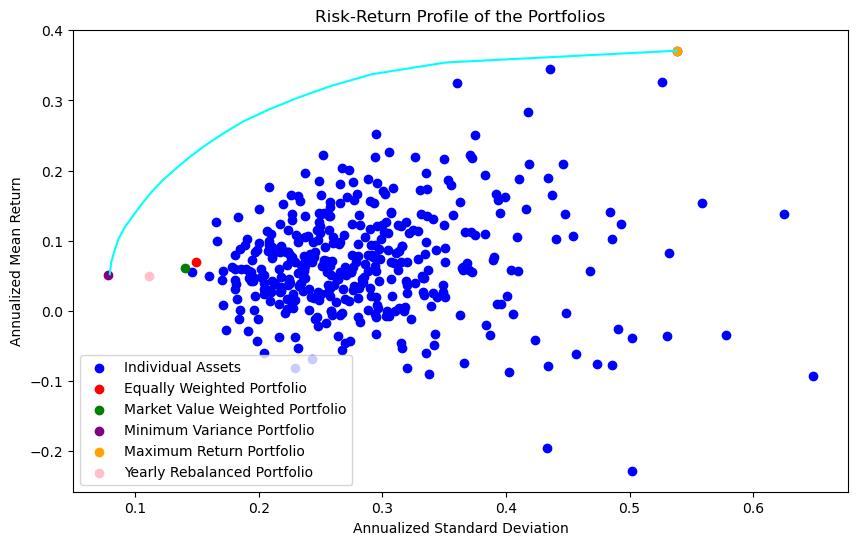

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(target_ann_std, target_ann_ret, color='cyan')
plt.scatter(annualization['annualized_std'], annualization['annualized_mean'], color='blue', label='Individual Assets')
plt.scatter(ew_ann_std, ew_ann_ret, color='red', label='Equally Weighted Portfolio')
plt.scatter(mw_ann_std, mw_ann_ret, color='green', label='Market Value Weighted Portfolio')
plt.scatter(minvar_ann_std, minvar_ann_ret, color='purple', label='Minimum Variance Portfolio')
plt.scatter(maxr_ann_std, maxr_ann_ret, color='orange', label='Maximum Return Portfolio')
plt.scatter(reb_ann_std, reb_ann_ret, color='pink', label='Yearly Rebalanced Portfolio')
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Mean Return')
plt.title('Risk-Return Profile of the Portfolios')
plt.legend()
plt.show()

In [ ]:
# Install seaborn if not already installed
%pip install seaborn

import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


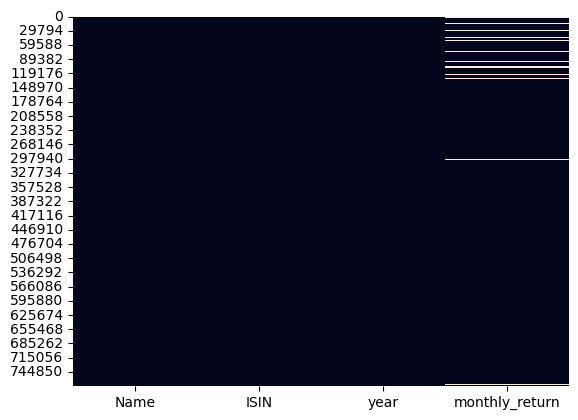

In [ ]:
plt.figure()

sns.heatmap(monthly_return_melted.isnull(), cbar=False)
plt.show()


In [ ]:
print('Done!')

Done!
